In [1]:
!nvidia-smi
!python --version
import tf2onnx

Fri Aug 30 12:53:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  |   00000000:2B:00.0  On |                  N/A |
| 30%   42C    P8             21W /  100W |    1884MiB /   8192MiB |     60%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---
# Ingest Data, Visualize and save to drive

Functions to load data and visualize fields

Saving to drive as single file to speed up load times

In [2]:
import numpy as np
import matplotlib.pyplot as plt

shape:  (144, 144) (144, 144) (145, 145)
shape:  (144, 144) (144, 144) (145, 145)


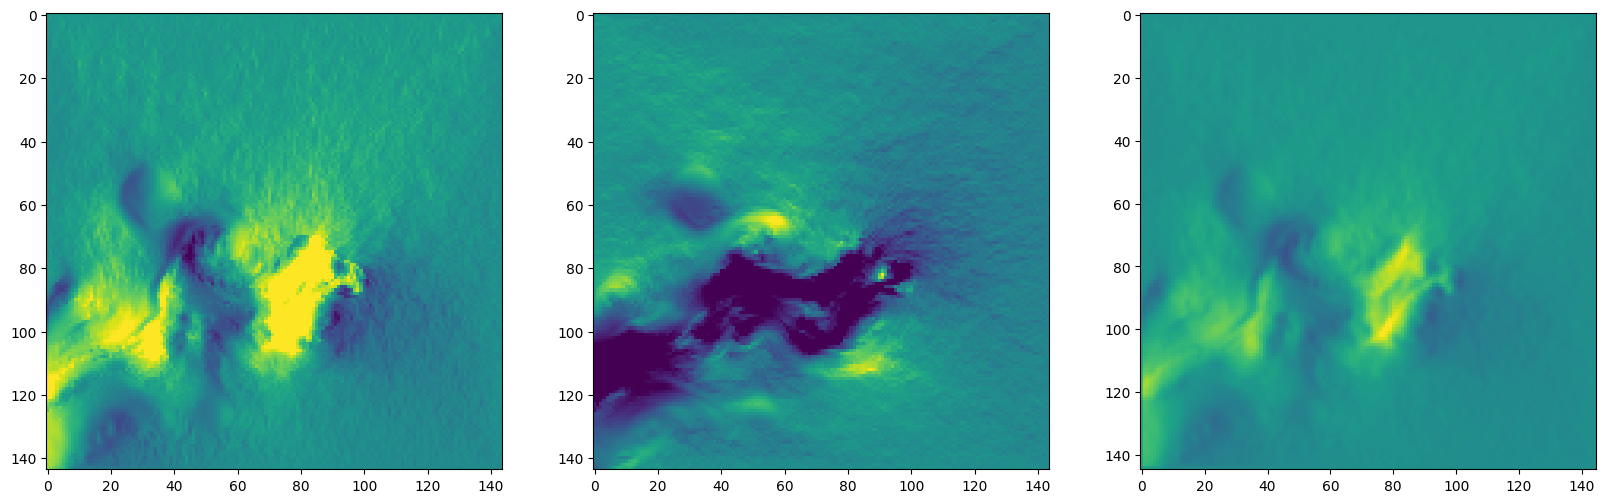

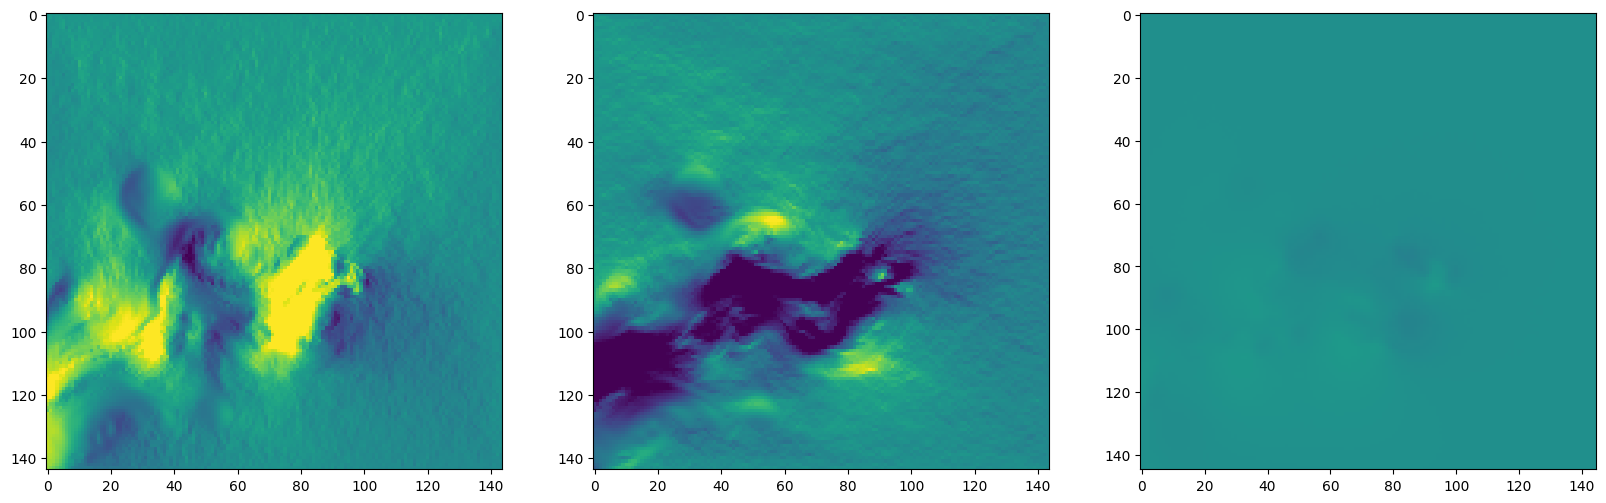

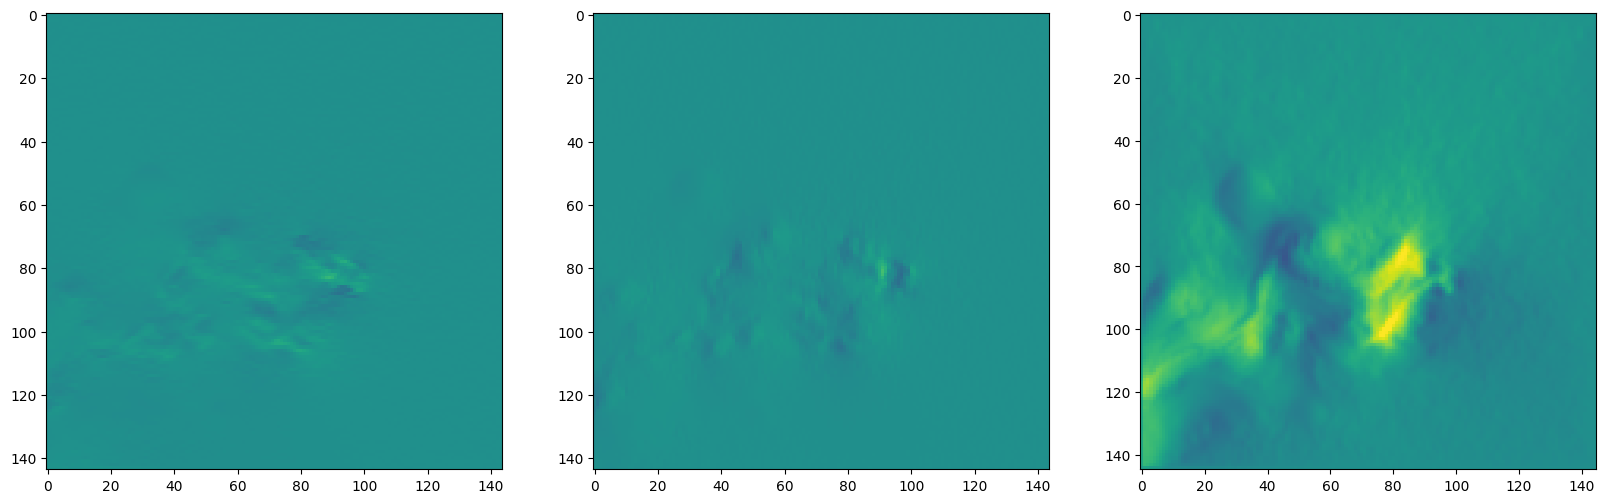

In [3]:
def plot_fields(fields, value_range=0.2):
    f = plt.figure( figsize=(20,12) )
    for idx, field in enumerate(fields):
        # Debug, plot figure
        f.add_subplot(1, 3, idx + 1)
        plt.imshow(field, vmin=-value_range, vmax=value_range)
    plt.show(block=True)
    
def show_fields_diff(inputfile1, inputfile2, value_scale=1/20):
    with np.load(inputfile1) as data:
        velx = data['velx'][:,:,0] * value_scale
        vely = data['vely'][:,:,0] * value_scale
        pres = data['pres'][:,:,0] * value_scale
        print("shape: ", velx.shape, vely.shape, pres.shape)
    with np.load(inputfile2) as data:
        velx2 = data['velx'][:,:,0] * value_scale
        vely2 = data['vely'][:,:,0] * value_scale
        pres2 = data['pres'][:,:,0] * value_scale
        print("shape: ", velx2.shape, vely2.shape, pres2.shape)
    
    fields1 = [velx, vely, pres]
    fields2 = [velx2, vely2, pres2]
    fields_diff = [velx-velx2, vely-vely2, pres-pres2]
        
    plot_fields(fields1)
    plot_fields(fields2)
    plot_fields(fields_diff)
    

testfile = ("./data2D/hou_data/v4/npz_train/pyro1.w5.1200.pre_project.npz")
testfile2 = ("./data2D/hou_data/v4/npz_train/pyro1.w5.1200.post_project.npz")
show_fields_diff(testfile, testfile2)

In [4]:
# ------------------------------
# LOAD DATA 2D -----------------
# ------------------------------
import os
import glob
import time

X_train_glob = sorted(glob.glob("./data2D/npz_train/pyro_bill*pre*"))
Y_train_glob = sorted(glob.glob("./data2D/npz_train/pyro_bill*post*"))
X_test_glob  = sorted(glob.glob("./data2D/npz_test/pyro_bill*pre*"))
Y_test_glob  = sorted(glob.glob("./data2D/npz_test/pyro_bill*post*"))

# used for scaling the data
scaler = 1/20

try:
    #find base shape:
    with np.load(X_train_glob[20]) as data:
        pres = data['pres'][:,:,0]
        target_shape = pres.shape
    print("TARGET SHAPE: ", target_shape)
except:
    pass

def load_sim_files(filelist, verbose=0):
    dir = os.path.dirname(filelist[0])
    perf_start = time.perf_counter()
    array = []
    total_files = len(filelist)
    
    print(f"\nStarting to load {total_files} files from {dir}.")
    for idx, file in enumerate(filelist):
        perf0 = time.perf_counter()  # PERF

        try:
            with np.load(file) as data:
                velx = data['velx'][:,:,0]
                vely = data['vely'][:,:,0]
                pres = data['pres'][:,:,0]
        except Exception:
            bad_filename = os.path.split(file)[1]
            bad_frame = bad_filename.split(".")[-3]
            bad_name = bad_filename.split(".")[0]
            source_folder = os.path.dirname(file)
            kill_filename = f"{bad_name}*{bad_frame}*"
            kill_selection = glob.glob(os.path.join(source_folder,kill_filename))
            print("kill_selection: ", kill_selection)

        if verbose:  # PERF
            print(f"Loading file Nr. {idx} from {total_files}")
            perf1 = time.perf_counter()
            print(f"\tP1 loaded data after: {(perf1 - perf0)*1000:.1f}ms"),

        velx = np.pad(velx, ((0,1),(0,1)))
        vely = np.pad(vely, ((0,1),(0,1)))

        #print("Minmax (Velx, Vely, Pres): \t{}\t{}\t{}\t{}\t{}\t{}\t\t{}".format(round(velx.min(),2), round(velx.max(),2), round(vely.min(),2), round(vely.max(),2), round(pres.min(),2), round(pres.max(),2), file))
        (round(velx.min(),2), round(velx.max(),2), round(vely.min(),2), round(vely.max(),2), round(pres.min(),2), round(pres.max(),2), file)
        #print(shapes)
        
        if verbose:  # PERF
            perf2 = time.perf_counter()
            print(f"\tP2 displayed min/max after: {(perf2 - perf1)*1000:.1f}ms")

        fields = np.stack([velx, vely, pres])
        fields = np.moveaxis(fields, 0, 2)
        fields = fields * scaler
        
        if verbose:  # PERF
            perf3 = time.perf_counter()
            print(f"\tP3 transformed data after: {(perf3 - perf2)*1000:.1f}ms")

        array.append(fields)

        if verbose:  # PERF
            perf4 = time.perf_counter()
            print(f"\tP4 appended array after: {(perf4 - perf3)*1000:.1f}ms")

    print(f"\n\t\tLoaded {total_files} files from: {dir}")
    print(f"\t\tTotal time taken: {time.perf_counter() - perf_start:.1f} seconds. \n")
    return array

if(len(X_train_glob)>0):
    X_train = load_sim_files(X_train_glob)
    Y_train = load_sim_files(Y_train_glob)

    X_test = load_sim_files(X_test_glob)
    Y_test = load_sim_files(Y_test_glob)


In [5]:
# # SAVE SPARSELY LOADED DATA TO SINGLE FILE:
# try:
#     print(X_train.shape)
#     np.savez_compressed("./data2D/loaded_data.npz",
#                         X_train = X_train,
#                         Y_train = Y_train,
#                         X_test = X_test,
#                         Y_test = Y_test)
# except:  
#     # if not defined, don't overwite files on disk
#     pass

---
# Load compiled data from disk
(faster loading)

Also calculating Y vel delta from Y(vel)-X(vel)

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    %cd "/content/drive/MyDrive/ML_RnD_pressurepredict"
except:
    IN_COLAB = False

In [7]:
combined_data_path = "./data2D/loaded_data.npz"
with np.load(combined_data_path) as data:
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    X_test  = data["X_test"]
    Y_test  = data["Y_test"]

Y_train_orig = Y_train.copy()
Y_test_orig  = Y_test.copy()

##### Change Y to vel_diff:
# Vel X
# Y_train[:,:,:,0] = Y_train_orig[:,:,:,0] - X_train[:,:,:,0]
for idx, Y in enumerate(Y_train_orig):
    Y_train[idx][:,:,0] = Y_train_orig[idx][:,:,0] - X_train[idx][:,:,0]  # X dim
    Y_train[idx][:,:,1] = Y_train_orig[idx][:,:,1] - X_train[idx][:,:,1]  # Y dim
for idx, Y in enumerate(Y_test_orig):
    Y_test[idx][:,:,0] = Y_test_orig[idx][:,:,0] - X_test[idx][:,:,0]  # X dim
    Y_test[idx][:,:,1] = Y_test_orig[idx][:,:,1] - X_test[idx][:,:,1]  # Y dim

del Y_train_orig
del Y_test_orig

In [8]:
print("Loaded X shape: ", np.array(X_train).shape, np.array(X_test).shape)
print("Loaded Y shape: ", np.array(Y_train).shape, np.array(Y_test).shape)

Loaded X shape:  (423, 107, 149, 3) (141, 107, 149, 3)
Loaded Y shape:  (423, 107, 149, 3) (141, 107, 149, 3)


In [9]:
# Resize inputs to random slices and flip randomly
def randomize_crop_data_2d(input_data, n, seed=42):
    """Function to transform input to random slices of 64 voxels (in 2D)

    Args:
        input_data (List of np.array): list of training data
        n (int): number of variations, looping through input

    """
    tf.random.set_seed(seed)
    np.random.seed(seed)
    input_shape = np.array(input_data).shape
    
    output = []
    for i in range(n):
        index = i % input_shape[0]
        source_sample = input_data[index]

        # Randomly crop to desired size using TensorFlow
        random_sample = tf.image.random_crop(source_sample, size=(64, 64, 3))

        # Randomly flip along either x or y
        flip_rng = np.random.random()
        if flip_rng < 1/3:
            if flip_rng < 2/3: axis = 0
            else: axis = 1
            random_sample = tf.image.flip_left_right(random_sample) if axis == 1 else tf.image.flip_up_down(random_sample)

        # Randomly rotate by 90 degrees
        rot_rng = int(np.random.random() * 4)
        random_sample = tf.image.rot90(random_sample, k=rot_rng)

        # Convert the tensor to a NumPy array before appending to the output list
        output.append(random_sample.numpy())

    return output

print("X_train:     ", X_train.shape)
print("X_test:      ", X_test.shape)

ntrain = 1500
ntest = round(ntrain/5)
X_train_rand = randomize_crop_data_2d(X_train, ntrain, seed=42)
Y_train_rand = randomize_crop_data_2d(Y_train, ntrain, seed=42)
X_test_rand  = randomize_crop_data_2d(X_test,  ntest,  seed=100)
Y_test_rand  = randomize_crop_data_2d(Y_test,  ntest,  seed=100)

print("X_train_rand: ", np.array(X_train_rand).shape)
print("X_test_rand:  ", np.array(X_test_rand).shape)

# 24-07-06 # BEWARE OF RANDOM SAMPLE FLIP AND ROTATE NOT WORKING

X_train:      (423, 107, 149, 3)
X_test:       (141, 107, 149, 3)
X_train_rand:  (1500, 64, 64, 3)
X_test_rand:   (300, 64, 64, 3)


## Visualize Loaded Data
Especially to sanity-check coherence of variations


Train X and Y at idx 10: 


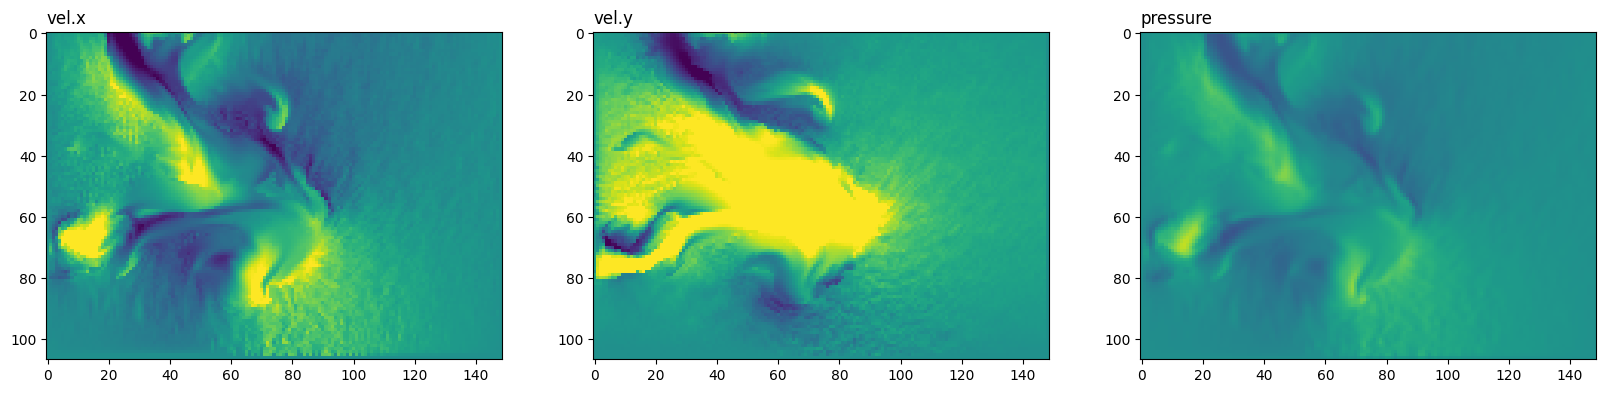

Minmax (Velx, Vely, Pres): 	-0.17	0.3	-0.2	0.48	-0.07	0.12


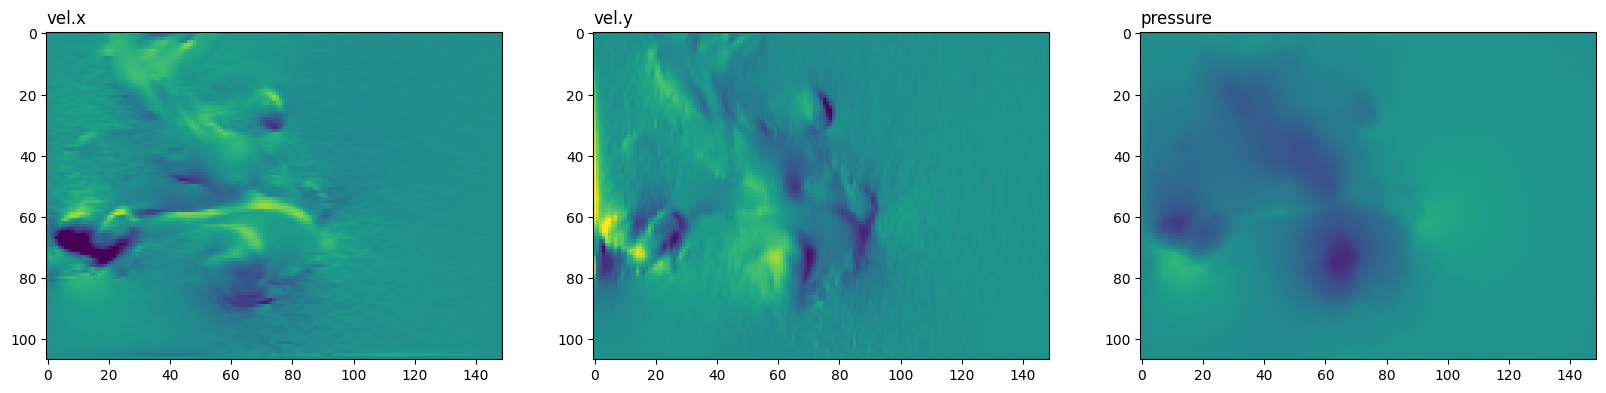

Minmax (Velx, Vely, Pres): 	-0.1	0.04	-0.05	0.06	-0.04	0.02


Random Variation Nr. 1 of same 


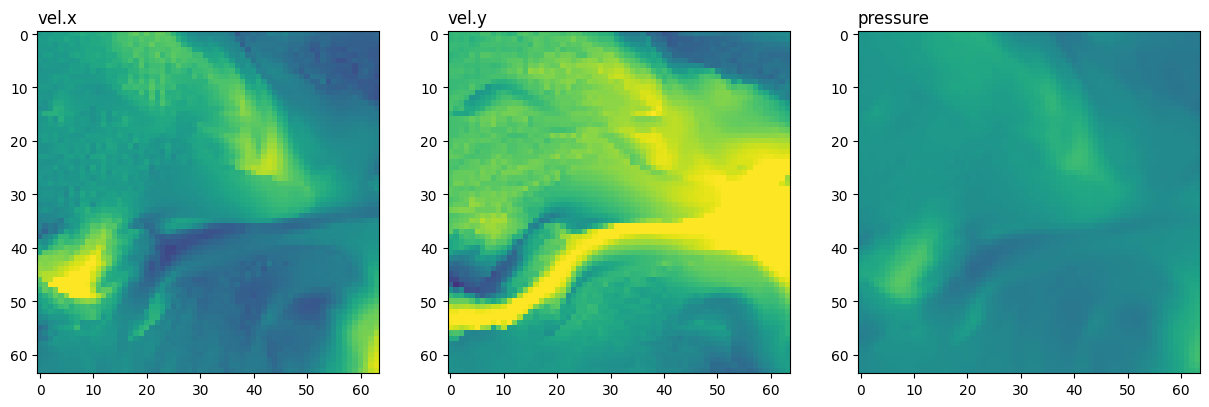

Minmax (Velx, Vely, Pres): 	-0.14	0.3	-0.18	0.47	-0.07	0.12


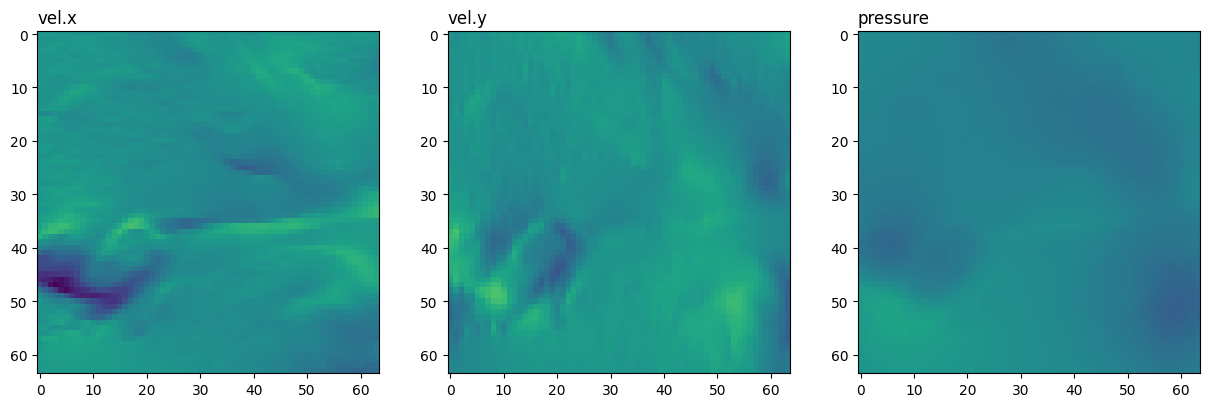

Minmax (Velx, Vely, Pres): 	-0.1	0.04	-0.05	0.04	-0.04	0.02


Random Variation Nr. 2 of same 


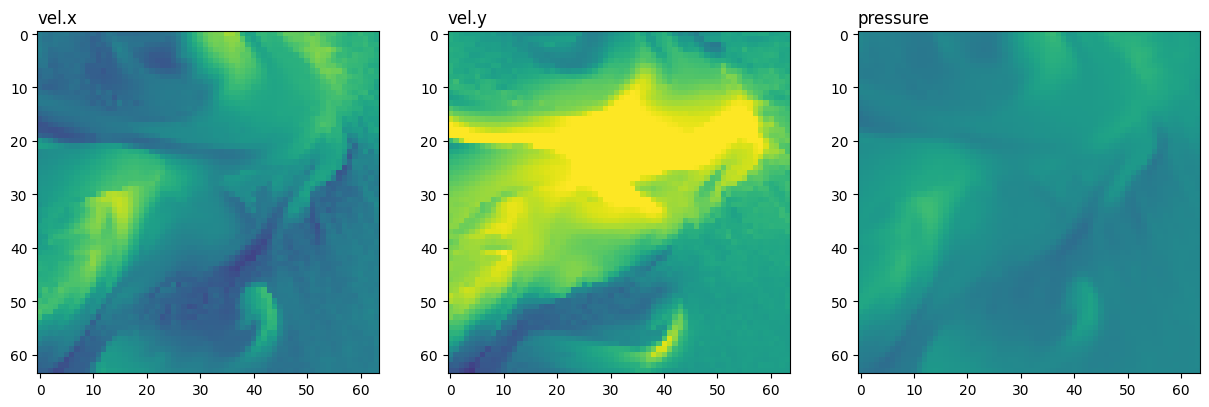

Minmax (Velx, Vely, Pres): 	-0.15	0.21	-0.17	0.48	-0.07	0.09


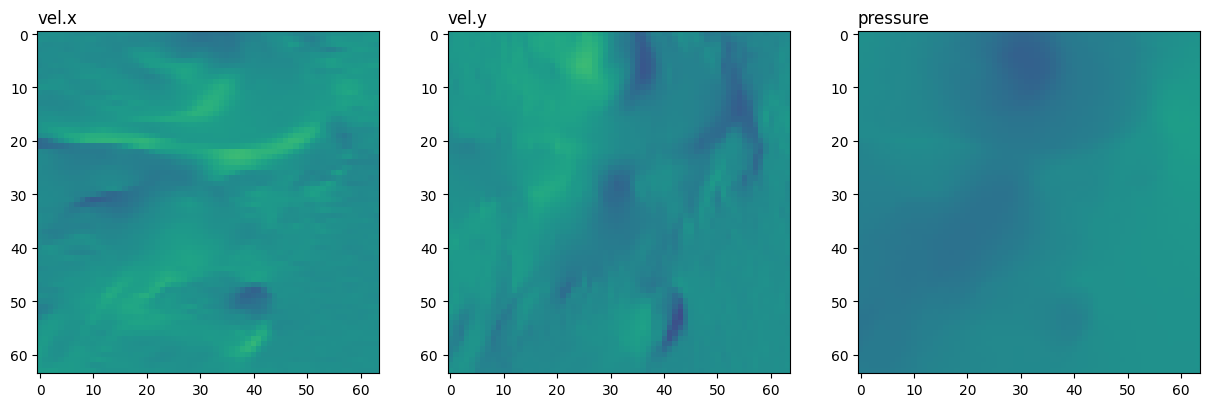

Minmax (Velx, Vely, Pres): 	-0.04	0.04	-0.05	0.04	-0.04	0.01


Random Variation Nr. 3 of same 


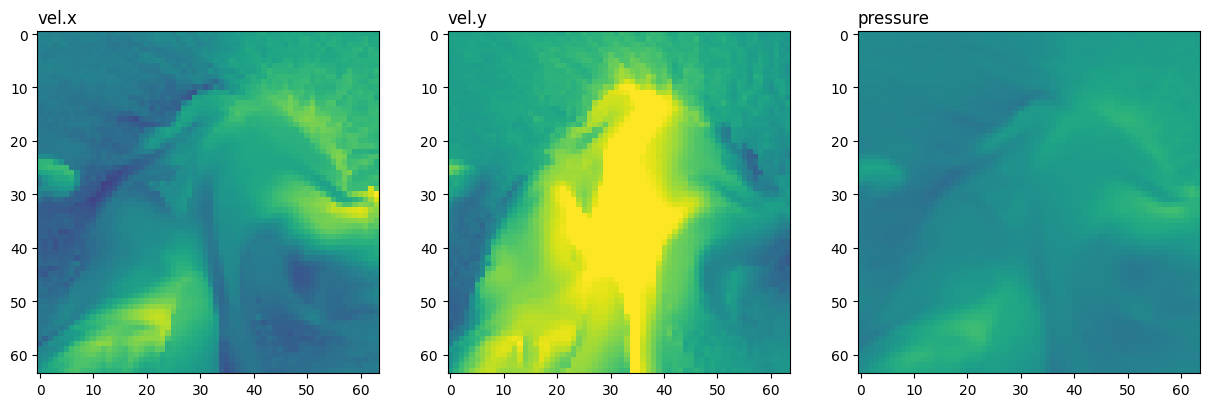

Minmax (Velx, Vely, Pres): 	-0.15	0.25	-0.11	0.48	-0.07	0.1


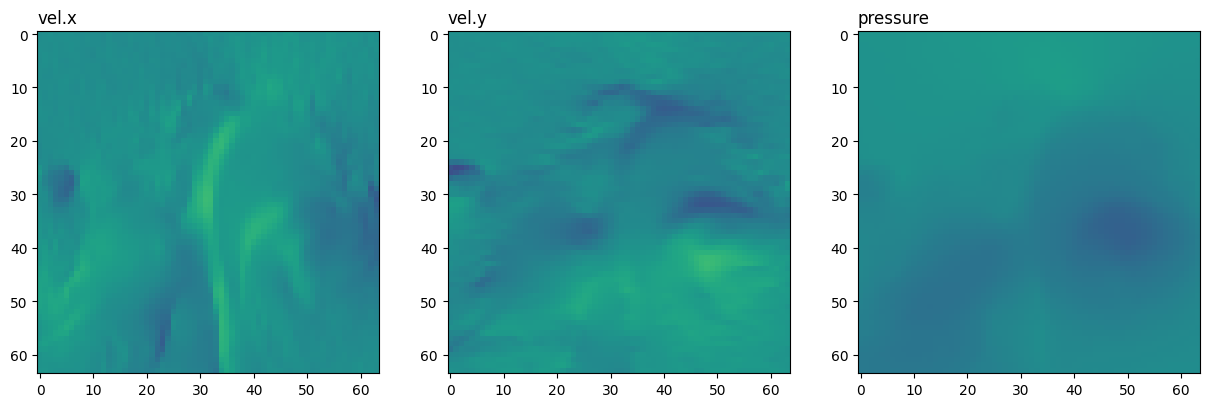

Minmax (Velx, Vely, Pres): 	-0.04	0.04	-0.05	0.04	-0.04	0.01


Random Variation Nr. 4 of same 


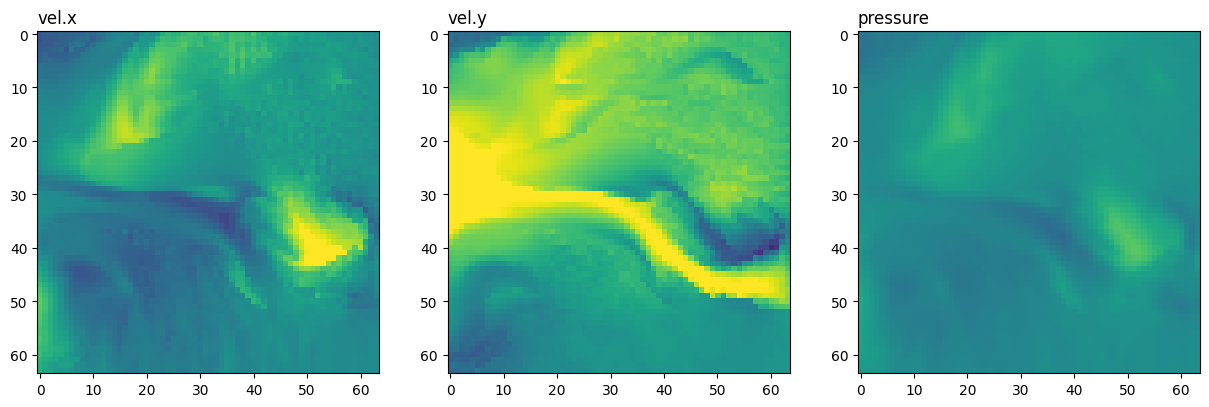

Minmax (Velx, Vely, Pres): 	-0.14	0.3	-0.2	0.47	-0.07	0.12


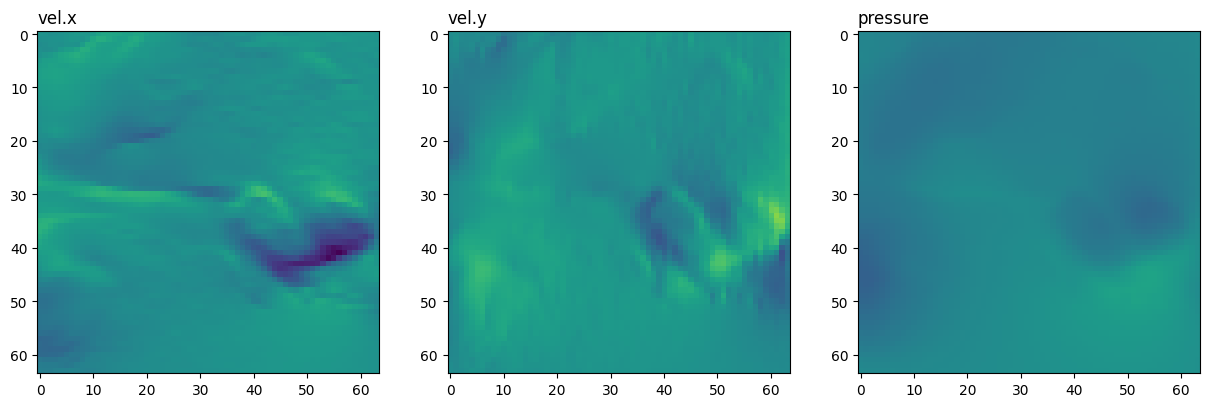

Minmax (Velx, Vely, Pres): 	-0.1	0.04	-0.05	0.06	-0.04	0.02


In [10]:
def show_fields_array(array, value_scale=0.15, size=(20,12)):
    '''Visualize a 3d Array of [VelX, VelY, Pres]'''
    velx = array[:,:,0]
    vely = array[:,:,1]
    pres = array[:,:,2]
    #print("shape: ", velx.shape, vely.shape, pres.shape)
    fields = [velx, vely, pres]
    titles = ["vel.x", "vel.y", "pressure"]
    f = plt.figure( figsize=size )
    for idx, field in enumerate(fields):
        # Debug, plot figure
        f.add_subplot(1, 3, idx + 1)
        plt.title(titles[idx], loc='left')
        plt.imshow(field, vmin=-value_scale, vmax=value_scale)
    plt.show(block=True)
    print("Minmax (Velx, Vely, Pres): \t{}\t{}\t{}\t{}\t{}\t{}".format(round(velx.min(),2), round(velx.max(),2), round(vely.min(),2), round(vely.max(),2), round(pres.min(),2), round(pres.max(),2)))

# Visualize first instance of train test split
prev_idx = 10
print(f"\nTrain X and Y at idx {prev_idx}: ")
show_fields_array(X_train[prev_idx], value_scale=.15)
show_fields_array(Y_train[prev_idx], value_scale=.05)

for i in range(4):
    var = len(X_train)*i + prev_idx
    print(f"\n\nRandom Variation Nr. {i+1} of same ")
    show_fields_array(X_train_rand[var], value_scale=.25, size=(15,8))
    show_fields_array(Y_train_rand[var], value_scale=.1, size=(15,8))



## Build Datasets
from tf.data.Dataset.from_tensor_slices

In [11]:
# APPLY BATCHING (with 1)
# ... and achieve output dimensionality of:     [2,     n, 64, 64, 3] 
# ... with desired iteration dimensionality of:     [None, 64, 64, 3]

train_dataset = tf.data.Dataset.from_tensor_slices( (np.array(X_train_rand), np.array(Y_train_rand)) )
train_dataset = train_dataset.shuffle(1500)
train_dataset = train_dataset.batch(5)

test_dataset = tf.data.Dataset.from_tensor_slices( (np.array(X_test_rand), np.array(Y_test_rand)) )
test_dataset = test_dataset.shuffle(300)
test_dataset = test_dataset.batch(5)

In [12]:
print("Sanity check iterable dimension: \n\t", tf.shape(next(iter(test_dataset))))

Sanity check iterable dimension: 
	 tf.Tensor([ 2  5 64 64  3], shape=(5,), dtype=int32)


---
# Build Generator
Referenced from pix2pix TF tutorial (https://www.tensorflow.org/tutorials/generative/pix2pix)

In [13]:
import tensorflow as tf
import numpy as np
import time

np.random.seed(42)
tf.random.set_seed(42)

# Determine input and coding size from
input_shape = X_train_rand[0].shape
# Define output dimensionality
OUTPUT_CHANNELS = 3

print("Input size: ", input_shape)

#tf.keras.mixed_precision.set_global_policy('float32')
# Set dtype to mixed precision for better perf.: Sometimes calculate in float 16
# Disabled for testing without GPU
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

Input size:  (64, 64, 3)


In [14]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())    

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def resnet_block(input_tensor, filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Add the skip connection (input + output)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.ReLU()(x)
    
    return x

def Generator():
    inputs = tf.keras.layers.Input(shape= input_shape )
    
    size = 3

    down_stack = [
        downsample(32,  size, apply_batchnorm=False),
        downsample(64,  size),
        downsample(128, size),
        downsample(256, size),
    ]
    
    num_res_blocks = 2  # This is an example; you can change it

    up_stack = [
        upsample(256, size, apply_dropout=True),
        upsample(128, size),
        upsample(64,  size),
        upsample(32,  size),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    # Adding ResNet blocks after downsampling
    for _ in range(num_res_blocks):
        x = resnet_block(x, filters=256)  # Adjust the filters as needed

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())    

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def resnet_block(input_tensor, filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Add the skip connection (input + output)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.ReLU()(x)
    
    return x

def Generator():
    inputs = tf.keras.layers.Input(shape= input_shape )
    
    size = 3

    down_stack = [
        downsample(32,  size, apply_batchnorm=False),
        downsample(64,  size),
        downsample(128, size),
        downsample(256, size),
    ]
    
    num_res_blocks = 2  # This is an example; you can change it

    up_stack = [
        upsample(256, size, apply_dropout=True),
        upsample(128, size),
        upsample(64,  size),
        upsample(32,  size),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    # Adding ResNet blocks after downsampling
    for _ in range(num_res_blocks):
        x = resnet_block(x, filters=256)  # Adjust the filters as needed

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
# test down and upsampling
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(X_train_rand[0], 0))
print (down_result.shape)

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 32, 32, 3)
(1, 64, 64, 3)


In [17]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 16, 16, 64)   18688       ['sequential_2[0][0]']           
                                                                                                  
 sequential_4 (Sequential)      (None, 8, 8, 128)    74240       ['sequential_3[0][0]']           
                                                                                              

In [18]:
#tf.keras.utils.plot_model(generator, show_shapes=True, show_dtype=True, dpi=64)

In [19]:
# ---------------------
# DEFINE GENERATOR LOSS
# ---------------------

LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(
        tf.cast(target,     tf.float32) - 
                gen_output
    ))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


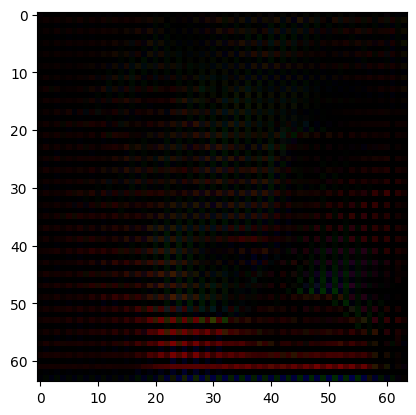

In [20]:
# Test the generator
value_range = 0.05
gen_output = generator(100*X_train_rand[24][tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...], vmin=-value_range, vmax=value_range)

---

# Build Discriminator
Referenced from pix2pix TF tutorial (https://www.tensorflow.org/tutorials/generative/pix2pix)

In [21]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=input_shape, name='input_image')
    tar = tf.keras.layers.Input(shape=input_shape, name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])
    
    down1 = downsample(32, 4, False)(x)
    down2 = downsample(64, 4)(down1)
    down3 = downsample(128, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(256, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [22]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 target_image (InputLayer)      [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 64, 64, 6)    0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']           
                                                                                                  
 sequential_10 (Sequential)     (None, 32, 32, 32)   3072        ['concatenate_3[0][0]']    

In [23]:
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

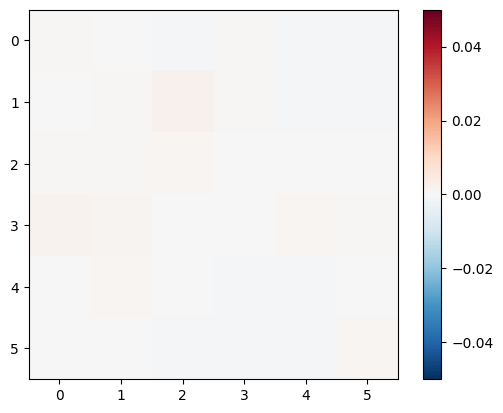

In [24]:
# Test the disriminator
disc_out = discriminator([X_train_rand[0][tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-value_range, vmax=value_range, cmap='RdBu_r')
plt.colorbar()

In [25]:
# Define discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [26]:
# Define optimizers and a checkpoint-saver
generator_optimizer = tf.keras.optimizers.Adam(2.5e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(9e-5, beta_1=0.5)

# TWEAK NOTES
# Tweaked overpowering discriminator by slowing learning rate from 2e-4 to 1e-4
# and speeding up generator to 2.5e-4 from 2e-4

In [27]:
import scipy

def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    value_range = .05

    display_list = [
        test_input[0][:,:,0], tar[0][:,:,0], prediction[0][:,:,0],
        test_input[0][:,:,1], tar[0][:,:,1], prediction[0][:,:,1],
        test_input[0][:,:,2], tar[0][:,:,2], prediction[0][:,:,2] 
    ]
    maintitle = ['Input Image', 'Ground Truth', 'Predicted Image']
    title = ['vel.x', 'vel.y', 'pressure']

    for i in range(9):
        plt_idx = i
        plt.subplot(3, 3, i+1)
        
        try: header = f"----- {maintitle[i]} -----"
        except: header = ""
        plt.title(f"{header}\n\n{title[i//3]}")
        
        # Getting the pixel values in the [0, 1] range to plot.
        a, b = 0.5, 0.1
        tile = display_list[i]
        if (i-2)%3 == 0:
            # Blur prediction with gaussian sigma
            BLUR_SIGMA = 0.35
            tile = scipy.ndimage.gaussian_filter(tile, BLUR_SIGMA)
        plt.imshow(tile, vmin=-value_range, vmax=value_range)
        plt.axis('off')
    plt.show()

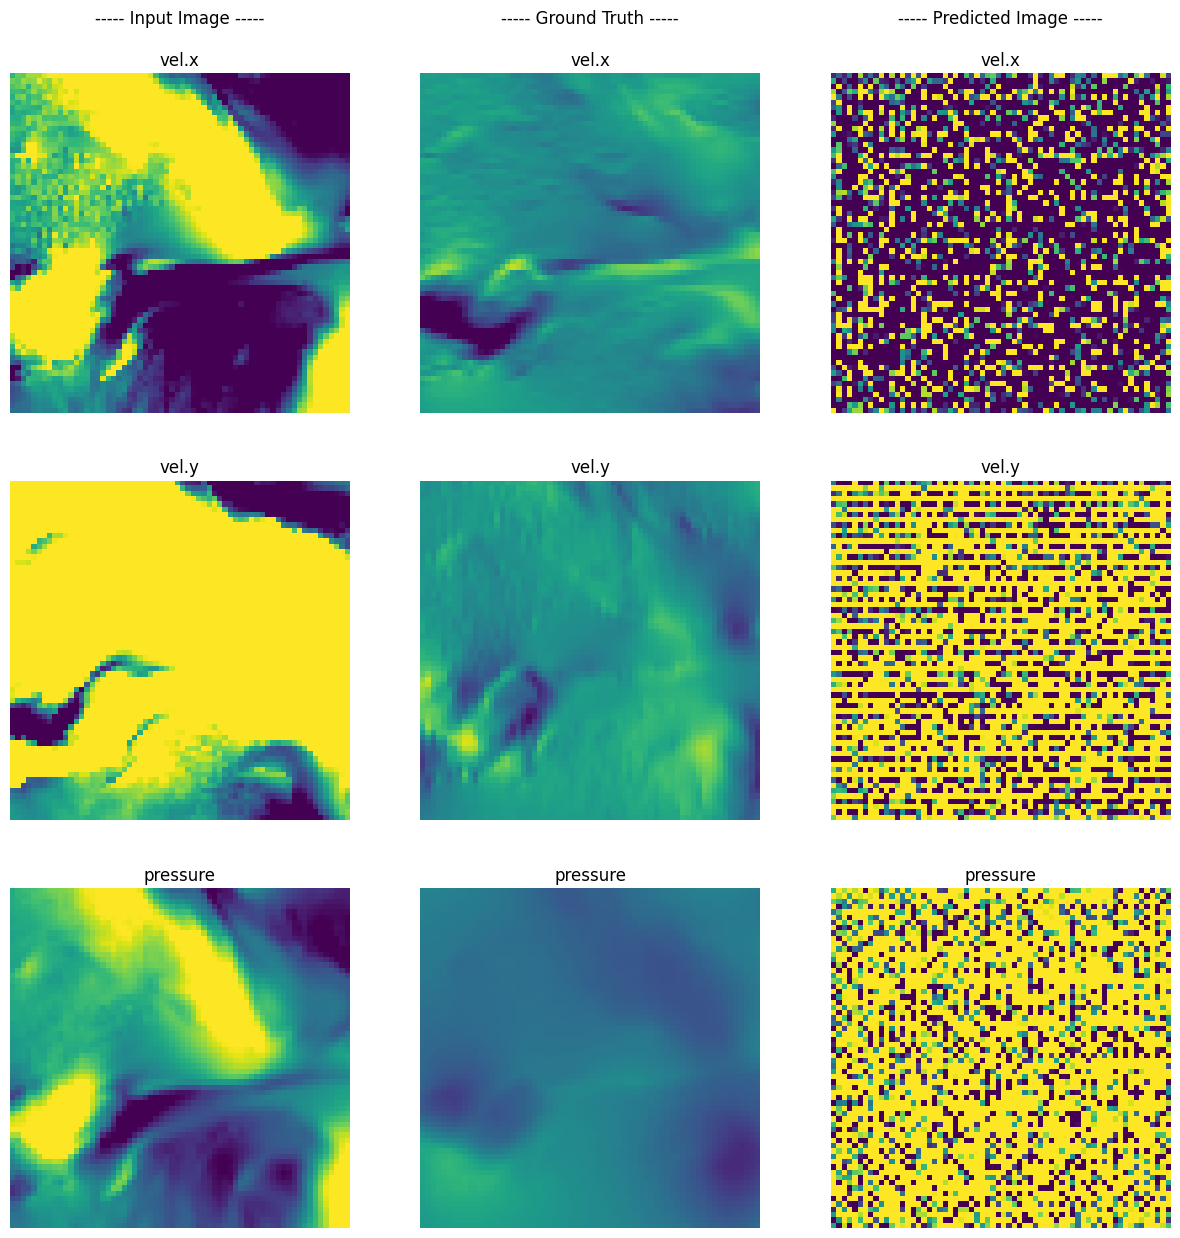

In [28]:
prev_idx = 10
generate_images(generator, X_train_rand[prev_idx][tf.newaxis, ...], Y_train_rand[prev_idx][tf.newaxis, ...])

---
# Training
- For each example input generate an output
- Discriminator receives (input image + generated output) and (input image + target image)
- Calculate generator and discriminator loss
- Calculate gradients of loss and apply to optimizer
- Log losses to TensorBoard

In [29]:
import time
import datetime
from IPython import display
log_dir="logs/"

# summary_writer = tf.summary.create_file_writer(
#   log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [30]:
############# Define checkpoint saver and directory

import os
checkpoint_dir = './training_checkpointsC'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [31]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

In [32]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# fit(train_dataset, test_dataset, steps=1000000)

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
generator.save(".\models\pressure_predict_tf2_Cv4.h5")

## Preview trained model:

In [34]:
# Load saved model
# generator = tf.keras.models.load_model(".\models\pressure_predict_tf2_Cv2.h5")
# print(generator.optimizer)

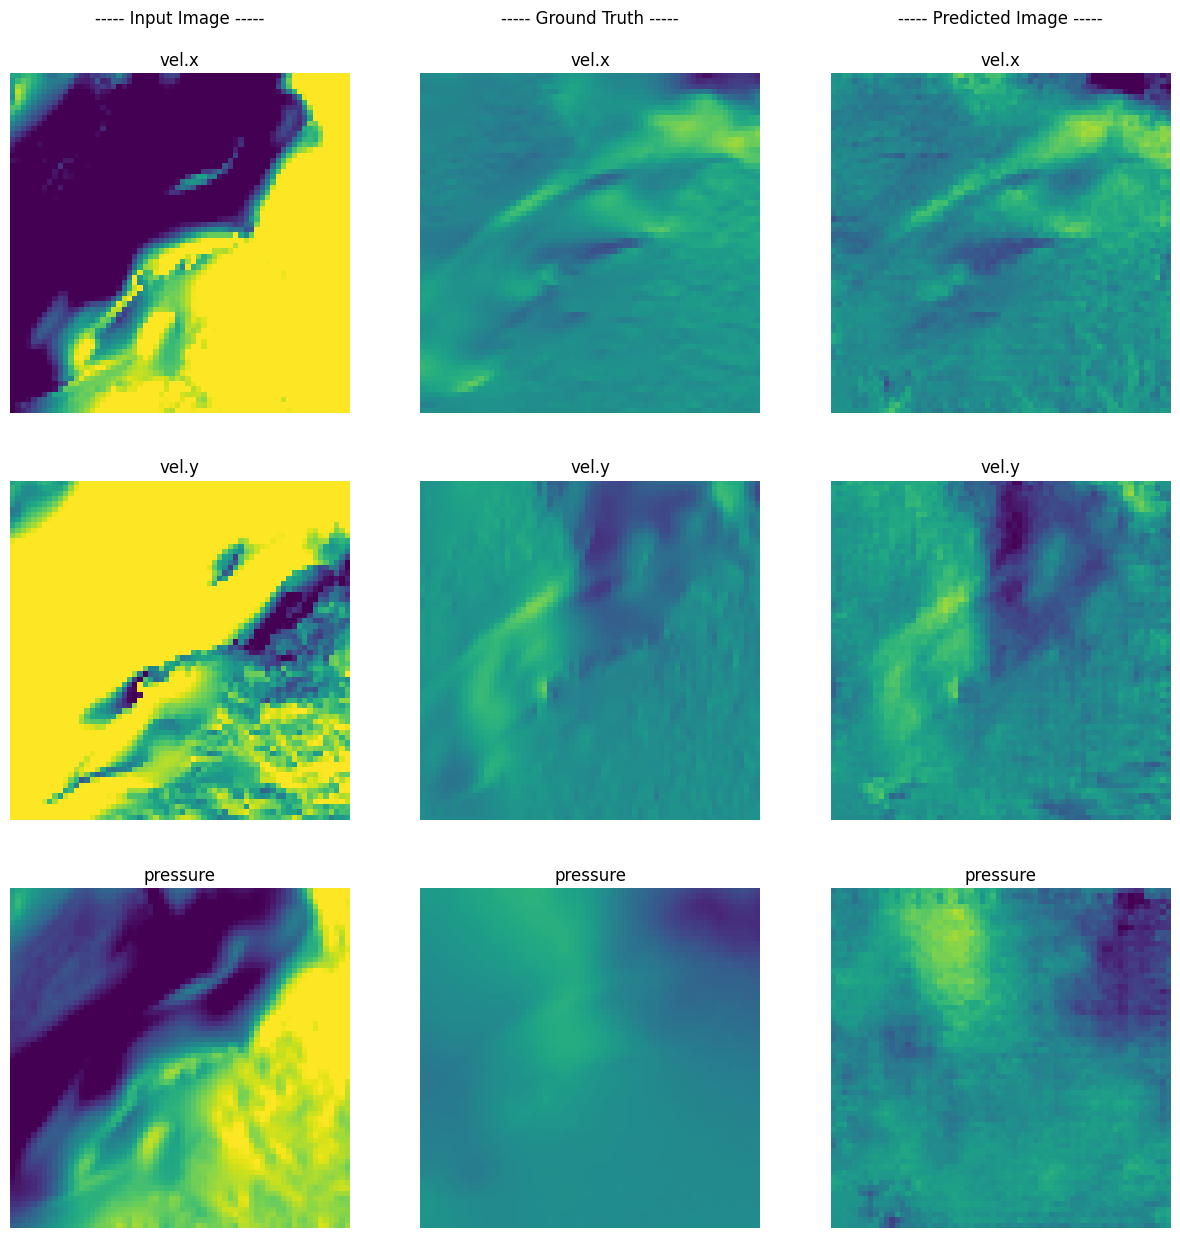

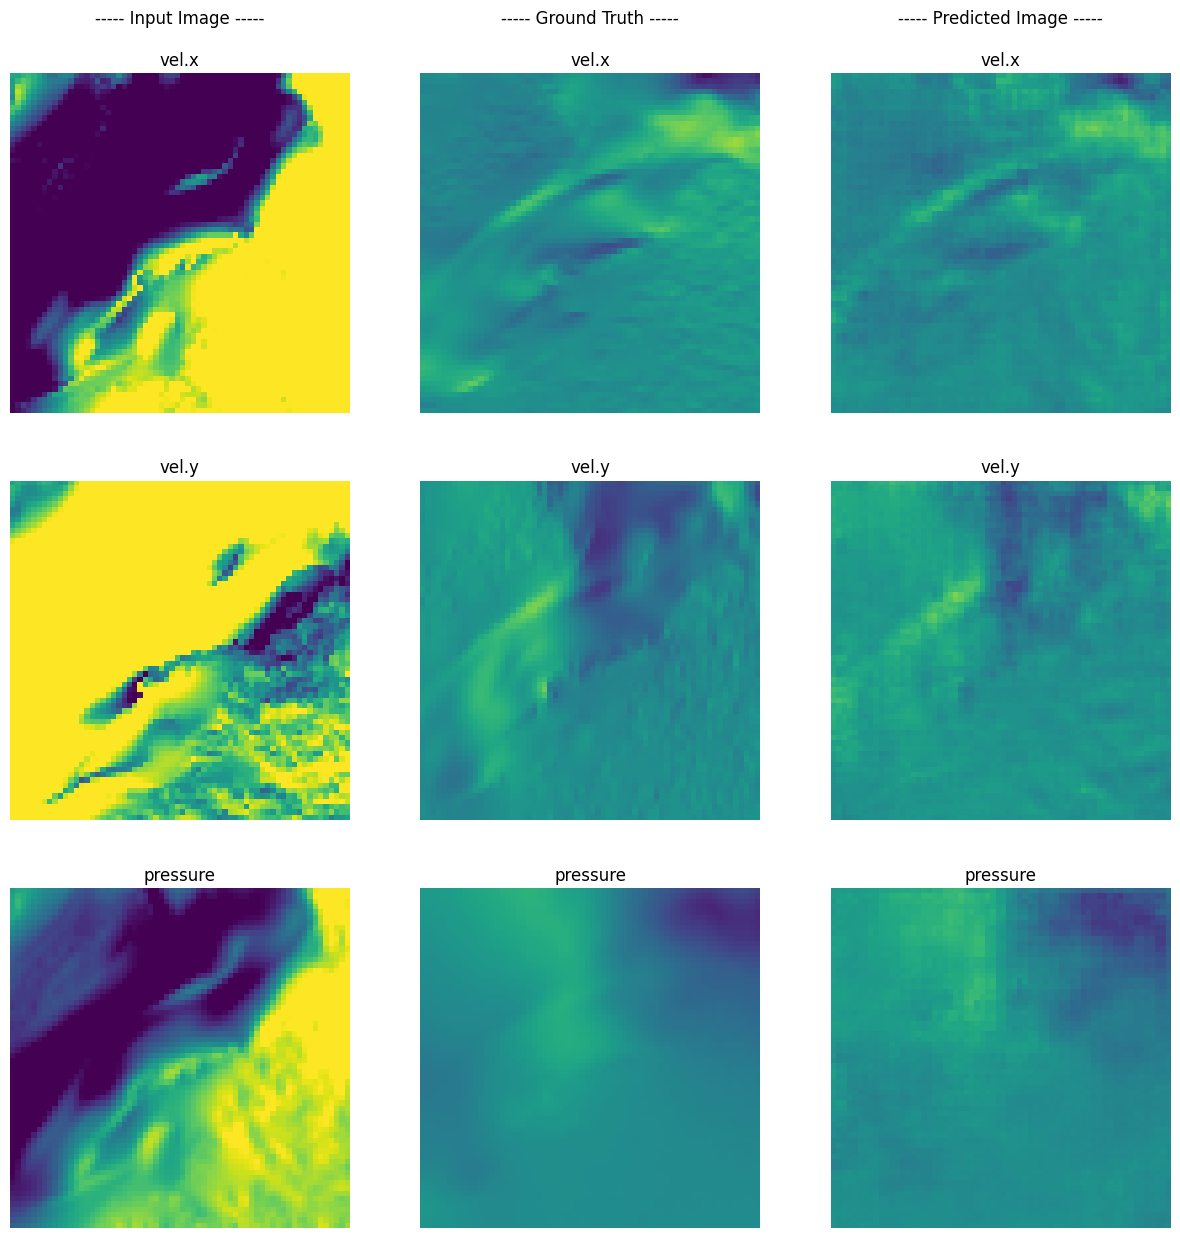

In [35]:
prev_idx = 40
generator = tf.keras.models.load_model(".\models\pressure_predict_tf2_Cv4.h5")
generate_images(generator, X_train_rand[prev_idx][tf.newaxis, ...], Y_train_rand[prev_idx][tf.newaxis, ...])
generator = tf.keras.models.load_model(".\models\pressure_predict_tf2_Cv2.h5")
generate_images(generator, X_train_rand[prev_idx][tf.newaxis, ...], Y_train_rand[prev_idx][tf.newaxis, ...])

## Export Model as ONNX:

In [40]:
import tf2onnx

# Load model
model = tf.keras.models.load_model(".\models\pressure_predict_tf2_Cv4.h5")

# Specify the output path for the ONNX model
output_path = ".\models\pressure_predict_tf2_Cv4.onnx"

# Convert the model
model_proto, _ = tf2onnx.convert.from_keras(model, opset=13)

# Save the model
with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())
# tf2onnx.utils.save_onnx_model(onnx_model, output_path)

print(f"Model successfully converted to ONNX and saved as {output_path}")

Model successfully converted to ONNX and saved as .\models\pressure_predict_tf2_Cv4.onnx
